In [1]:
import sys
sys.path.append('../utils')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from MiguelTK import *
import warnings
warnings.filterwarnings('ignore')

## Limpieza y transformación de datos

In [2]:
df = pd.read_csv('data/ZARA_db.csv')

In [3]:
df.head()

,extracción,articulo,precio,descripcion,grupo_web,tallas,colores,enlace,marca,grupo,seccion
0,2024-05-25 11:53:38.599586,CAMISETA CROP EFECTO TOALLA BORDADO,15.95,Camiseta corta amplia confeccionada en tejido ...,V2024-MUJER-ULTIMA-SEMANA,"['S', 'M', 'L']",[],https://www.zara.com/es/es/camiseta-crop-efect...,ZARA,CAMISETA,MUJER
1,2024-05-25 11:53:38.599586,VESTIDO TUL ESTAMPADO CUT OUT,22.95,Vestido corto de cuello redondo y manga sisa. ...,V2024-MUJER-ULTIMA-SEMANA,"['S', 'M', 'L']",[],https://www.zara.com/es/es/vestido-tul-estampa...,ZARA,VESTIDO,MUJER
2,2024-05-25 11:53:38.599586,FALDA TUL ESTAMPADA,17.95,Falda midi de tiro alto con cintura elástica. ...,V2024-MUJER-ULTIMA-SEMANA,"['S', 'M', 'L']",[],https://www.zara.com/es/es/falda-tul-estampada...,ZARA,FALDA,MUJER
3,2024-05-25 11:53:38.599586,BLAZER ABIERTA CON LINO,39.95,Blazer confeccionada con lino. Cuello solapa y...,V2024-MUJER-ULTIMA-SEMANA,"['XS', 'S', 'M', 'L', 'XL', 'XXL']","['Blanco', 'Marino']",https://www.zara.com/es/es/blazer-abierta-con-...,ZARA,BLAZER,MUJER
4,2024-05-25 11:53:38.599586,BODY TUL DRAPEADO ASIMÉTRICO,17.95,Body de escote asimétrico con manga sisa. Teji...,V2024-MUJER-ULTIMA-SEMANA,"['S', 'M', 'L']","['Lila claro', 'Leopardo', 'Azul claro', 'amar...",https://www.zara.com/es/es/body-tul-drapeado-a...,ZARA,BODY,MUJER


In [4]:
df['temporada'] = df['grupo_web'].str.extract(r'^(\w+)\-')
del df['grupo_web']

In [5]:
df['n_tallas'] = df['tallas'].str.count(r'\'(\w+)\'')

In [6]:
del df['enlace']

In [7]:
df['n_colores'] = df['colores'].str.count(r'\'(\w+)\'')

In [8]:
df['contiene_lino'] = df['descripcion'].str.contains(r'lino',case=False)

In [9]:
df['contiene_algodon'] = df['descripcion'].str.contains(r'algodón',case=False)

In [10]:
df['tipo_talla'] = (
    df['tallas']
    .str.contains(r'\d')
    .map({
        True:'numérica',
        False:'alfabética'
    })
)

In [11]:
df['colores'] = df['colores'].str.upper()

## Estudio de colores

In [12]:
tabla_colores = (
    df['colores']
    .str.replace(r'[\[\]\']','',regex=True)
    .str.replace(r'\,\s',',',regex=True)
    .str.split(',',expand=True)
    .assign(seccion = df['seccion'])
    .melt('seccion')
    .drop(columns='variable')
    .dropna(subset='value')
    .query('value != ""')
)
tabla_colores

,seccion,value
3,MUJER,BLANCO
4,MUJER,LILA CLARO
5,MUJER,BLANCO
11,MUJER,KHAKI
19,MUJER,NEGRO
...,...,...
9525,HOMBRE,BEIGE
9530,HOMBRE,AZUL MEDIO
10280,HOMBRE,NEGRO
10460,HOMBRE,ARENA


In [13]:
B_N = (
    tabla_colores
    ['value']
    .str.contains(r'(NEGRO)|(BLANCO)',regex=True)
)

Colores más frecuentes por sección (diferentes al blanco y negro)


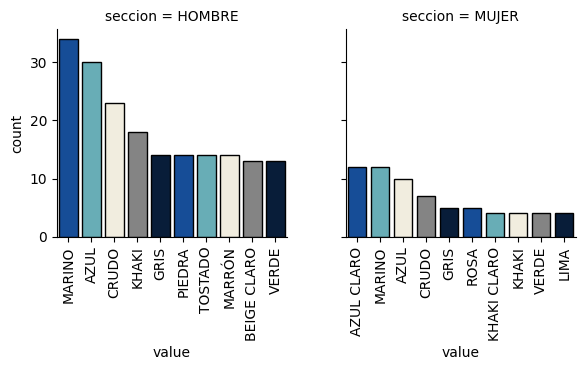

In [14]:
df_ = (
    tabla_colores[~B_N]
    .groupby('seccion',as_index=False)
    ['value']
    .value_counts()
    .groupby('seccion')
    .apply(lambda x: x.nlargest(10,'count'))
)
grid = sns.FacetGrid(df_,col='seccion',sharex=False)
grid.map(sns.barplot,'value','count',**kwargs)
grid.tick_params('x',rotation=90)
print('Colores más frecuentes por sección (diferentes al blanco y negro)')

In [15]:
df_ = (
    tabla_colores[~B_N]
    .groupby('seccion',as_index=False)
    ['value']
    .value_counts()
    .groupby('seccion')
    .apply(lambda x: x.nsmallest(10,'count'))
    .drop(columns='seccion')
    .reset_index()
    .drop(columns=['level_1','count'])
)
print('Colores menos frecuentes por sección (diferentes al blanco y negro)')
print(df_)

Colores menos frecuentes por sección (diferentes al blanco y negro)
   seccion           value
0   HOMBRE  ROSA EMPOLVADO
1   HOMBRE    VISÓN VIGORÉ
2   HOMBRE         BOTELLA
3   HOMBRE      GRIS MEDIO
4   HOMBRE  CRUDO / VIGORÉ
5   HOMBRE    CRUDO / AZUL
6   HOMBRE           CREMA
7   HOMBRE    CORAL FUERTE
8   HOMBRE   CELESTE CLARO
9   HOMBRE        CARAMELO
10   MUJER      ROSA MEDIO
11   MUJER      VERDE LIMA
12   MUJER     VERDE MEDIO
13   MUJER  TOSTADO OSCURO
14   MUJER       ROSA TIZA
15   MUJER     CAMEL CLARO
16   MUJER      ROSA FLÚOR
17   MUJER     BEIGE CLARO
18   MUJER    ROJO BURDEOS
19   MUJER           PLOMO


<Axes: xlabel='seccion', ylabel='n_colores'>

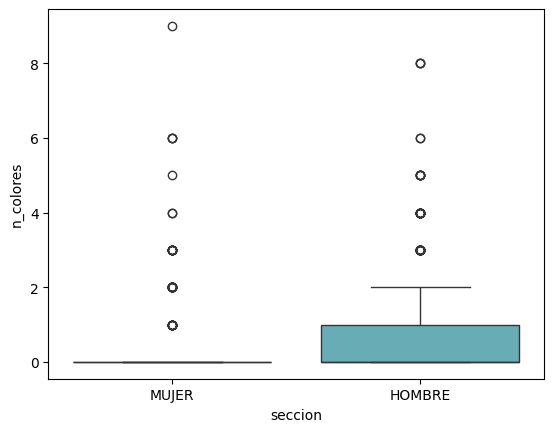

In [16]:
sns.boxplot(
    data = df,
    x = 'seccion',
    y = 'n_colores',
    palette = palette
)

La ropa masculina tiene mayor variedad en los colores disponibles.

## Estudio de composición

In [17]:
df['contiene_lino'].value_counts(normalize=True)

contiene_lino
False    0.893048
True     0.106952
Name: proportion, dtype: float64

El `11 %` de las prendas de ropa contienen lino

In [18]:
df['contiene_algodon'].value_counts(normalize=True)

contiene_algodon
False    0.855615
True     0.144385
Name: proportion, dtype: float64

El `15 %` de las prendas de ropa contienen algodón

In [19]:
pd.crosstab(
    df['contiene_lino'],
    df['seccion'],
    normalize='index'
)

seccion,HOMBRE,MUJER
contiene_lino,,
False,0.609581,0.390419
True,0.560000,0.440000


In [20]:
pd.crosstab(
    df['contiene_algodon'],
    df['seccion'],
    normalize='index'
)

seccion,HOMBRE,MUJER
contiene_algodon,,
False,0.565000,0.435000
True,0.837037,0.162963


Las prendas de ropa que contienen o bien lino o bien algodón tienen más posibilidades de ser de la sección masculina.

<Axes: xlabel='contiene_lino', ylabel='precio'>

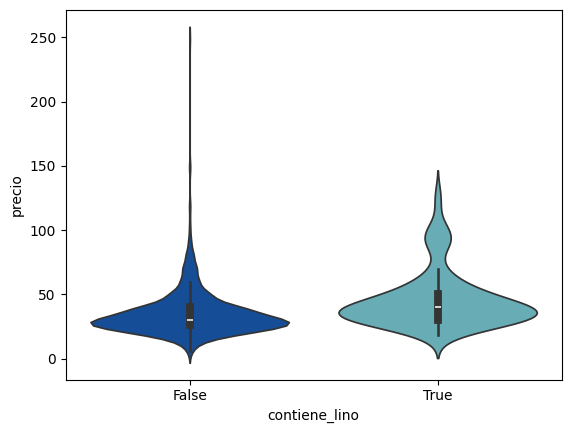

In [21]:
sns.violinplot(
    data = df,
    x = 'contiene_lino',
    y = 'precio',
    palette = palette
)

Las prendas que contienen `lino` pueden tener precios más altos que las que no lo contienen.

## Estudio de tallas

### Tallas extremas

#### Tallas letras

In [22]:
df_ = df.query('tipo_talla == "alfabética"')

In [23]:
pd.crosstab(
    df_['tallas'].str.contains('XS'),
    df_['seccion'],
    normalize = 'index'
)

seccion,HOMBRE,MUJER
tallas,,
False,0.799257,0.200743
True,0.004367,0.995633


In [24]:
pd.crosstab(
    df_['tallas'].str.contains('XL'),
    df_['seccion'],
    normalize = 'index'
)

seccion,HOMBRE,MUJER
tallas,,
False,0.421384,0.578616
True,0.598684,0.401316


In [25]:
pd.crosstab(
    df_['tallas'].str.contains('XXL'),
    df_['seccion'],
    normalize = 'index'
)

seccion,HOMBRE,MUJER
tallas,,
False,0.593974,0.406026
True,0.242857,0.757143


- Las prendas que tienen la talla `XS` disponible pertenecen casi todas a la sección femenina. 
- Las prendas con las talla `XL` disponible están en mayor equilibrio.
- Las prendas que tienen disponible la talla `XXL` pertenecen en mayor proporción a la sección femenina, y las que no tienen esa talla disponible son en su mayoría de caballero.

### Número de tallas disponibles

<Axes: xlabel='seccion', ylabel='n_tallas'>

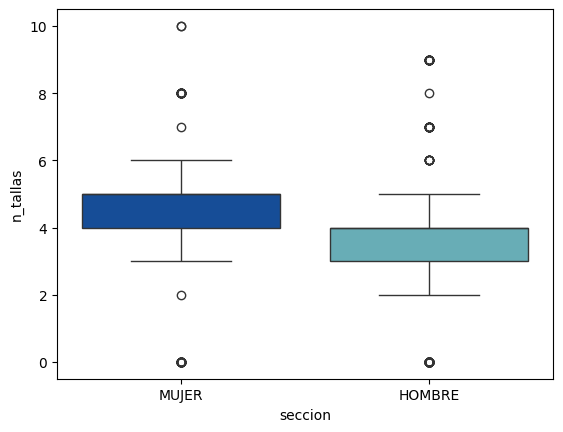

In [28]:
sns.boxplot(
    data = df,
    x = 'seccion',
    y = 'n_tallas',
    palette = palette
)

La ropa de la sección de mujer ofrece una mayor variedad de tallas.

## Palabras clave
porcentaje de prendas cuya descripción contiene la palabra clave:

In [29]:
# RELAXED
df['descripcion'].str.contains('relaxed').sum() / len(df)

0.13796791443850268

In [30]:
# FIT
df['descripcion'].str.contains('fit').sum() / len(df)

0.2887700534759358

In [31]:
# BRILLOS
df['descripcion'].str.contains(r'brillos?',case=False).sum() / len(df)

0.008556149732620321

In [32]:
# ESTAMPADO ANIMAL
df['descripcion'].str.contains(r'estampado\sanimal',case=False,regex=True).sum() / len(df)

0.0021390374331550803

In [33]:
# ASIMÉTRICO
df['descripcion'].str.contains(r'asimétric[oa]',case=False).sum() / len(df)

0.014973262032085561

In [34]:
# OVERSIZE
df['descripcion'].str.contains(r'over\s?size',case=False).sum() / len(df)

0.006417112299465241

In [35]:
# EFECTO ARRUGADO
df['descripcion'].str.contains(r'efecto arrugado',case=False).sum() / len(df)

0.0053475935828877